In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from PIL import Image
%matplotlib inline

In [3]:
class Network(object):
    
    def __init__(self, layer_node): #layer_node is a list contains the number of nodes in each layer
        self.num_layer = len(layer_node)
        self.layer_node = layer_node
        self.input_node = []
        #self.node = [ np.random.randn(num_node,1) for num_node in layer_node ]
        self.weights = [ np.random.randn(next_node,previous_node+1) for next_node, previous_node in zip(layer_node[1:],layer_node[:-1]) ]
        
    def add_input_node(self,input_vector): #must be of size (n,1)
        if len(input_vector) == self.layer_node[0]: 
            self.input_node = np.append([[1]],input_vector, axis=0) # add bias node
        else:
            print "Input vector length invalid: given len {1}, need len {0}".format(self.layer_node[0], len(input_vector))
            
    def forward_propagation(self):
        output_vector = self.input_node
        for weight in self.weights: 
            #print weight.shape
            #print output_vector.shape
            s = np.dot(weight, output_vector)
            output_vector = np.append([[1]], output_transformation(s), axis=0) # add bias node -> size (n+1,1)
        return output_vector[1:] # we omit the bias node 
        
    def backpropagation(self,input_vector, output_vector):
        s = [] # vector before entering node
        x = [np.append([[1]],input_vector, axis=0)] # vector after entering node
        sensitivity = [ np.zeros([1,i]) for i in self.layer_node[1:] ]
        #print len(sensitivity)
        
        #feedforward, save all the node coefs of each layer
        for weight in self.weights:
            s.append(np.dot(weight, x[-1]))
            x.append(np.append([[1]], output_transformation(s[-1]), axis=0))
            
        sensitivity[-1] = 2*(x[-1][1:] - output_vector) # omit the bias node 
        
        #backpropagation, compute sensitivity backward
        for layer_index in xrange(2, self.num_layer):
            w = self.weights[-layer_index+1]
            #print w
            #print w.shape
            #print sensitivity[-layer_index+1].shape
            
            sensitivity[-layer_index] = (np.dot(w.T,sensitivity[-layer_index+1]))[1:] #excluding the bias componnent which has the index 0
            
        return x, sensitivity
    
    def SGD(self, training_data, testing_data, eta, epochs): #stochastic gradient descent
        MSE_list = []
        for epoch in xrange(epochs): 
            MSE = 0 
            for index, row in training_data.iterrows():
                vector = np.array(row).reshape(3,1) 
                input_vector, output_vector = vector[:2], vector[2:]
                x, sensitivity = self.backpropagation(input_vector, output_vector)
                gradient = [ np.random.randn(next_node,previous_node+1) 
                            for next_node, previous_node in zip(self.layer_node[1:],self.layer_node[:-1])]
                for l in xrange(len(gradient)):
                    #print x[l].shape
                    #print sensitivity[l].shape
                    gradient[l] = np.dot(sensitivity[l],np.transpose(x[l]))
                    self.weights[l] = self.weights[l] - eta*gradient[l]
            MSE = self.evaluate(testing_data)
            MSE_list.append(MSE)
            print "Epoch {0}: MSE = {1}".format(epoch+1, MSE)
            #print
        return MSE_list
    
    def evaluate(self,testing_data):
        MSE = 0
        for index, row in testing_data.iterrows():
            vector = np.array(row).reshape(3,1) 
            input_vector, output_vector = vector[:2], vector[2:]
            self.add_input_node(input_vector)
            predicted_vector = self.forward_propagation()
            #print predicted_vector, output_vector
            MSE += np.abs(predicted_vector - output_vector)
        return MSE[0][0]/testing_data.shape[0]

            

In [4]:
def output_transformation(z):
    return z # linear regression -> identity function

In [50]:
data = pd.read_csv('donneespb4.txt', sep=' ', header=None)

In [51]:
data.columns = ['x','y','z']

In [52]:
data.head()

,x,y,z
0,"318,486003167222","121,206839602071","0,8"
1,"92,3891997532571","169,196157515606","0,2"
2,"87,9680665725936","184,310915080975","0,2"
3,"92,9280586133405","272,455903502393","0,2"
4,"210,182290901515","400,242635770814","0,8"


In [53]:
def str_to_float(df): 
    new_df = df.copy()
    return new_df.applymap(lambda x: float(x.replace(',','.')))

In [54]:
data = str_to_float(data)

In [55]:
data.describe()

,x,y,z
count,3000.000000,3000.000000,3000.00000
mean,202.815977,248.171568,0.36440
std,108.686071,100.202371,0.26765
min,80.002399,50.024106,0.20000
25%,97.226486,164.714578,0.20000
50%,165.254148,246.107113,0.20000
75%,306.658322,335.431398,0.80000
max,399.924324,449.796310,0.80000


In [56]:
def normalize(df): 
    new_df = df.copy()
    new_df[['x','y']] = new_df[['x','y']] / 500
    return new_df

In [57]:
data = normalize(data)
data.describe()

,x,y,z
count,3000.000000,3000.000000,3000.00000
mean,0.405632,0.496343,0.36440
std,0.217372,0.200405,0.26765
min,0.160005,0.100048,0.20000
25%,0.194453,0.329429,0.20000
50%,0.330508,0.492214,0.20000
75%,0.613317,0.670863,0.80000
max,0.799849,0.899593,0.80000


In [58]:
train = data.iloc[:2700]
train.shape

(2700, 3)

In [59]:
test = data.iloc[2700:]
test.shape

(300, 3)

In [60]:
neural_net = Network([2,10,1])

In [61]:
MSE = neural_net.SGD(training_data = train, testing_data = test, eta = 0.01, epochs = 50)

Epoch 1: MSE = 0.175320629216
Epoch 2: MSE = 0.176055085448
Epoch 3: MSE = 0.176450524787
Epoch 4: MSE = 0.176564023602
Epoch 5: MSE = 0.176450019711
Epoch 6: MSE = 0.176160967553
Epoch 7: MSE = 0.175745932135
Epoch 8: MSE = 0.175248952652
Epoch 9: MSE = 0.174707861958
Epoch 10: MSE = 0.174153701986
Epoch 11: MSE = 0.173610667402
Epoch 12: MSE = 0.173096459896
Epoch 13: MSE = 0.172622938983
Epoch 14: MSE = 0.172196966777
Epoch 15: MSE = 0.17182135279
Epoch 16: MSE = 0.17149581349
Epoch 17: MSE = 0.171217874484
Epoch 18: MSE = 0.170983661867
Epoch 19: MSE = 0.170788551269
Epoch 20: MSE = 0.170627664556
Epoch 21: MSE = 0.170496221657
Epoch 22: MSE = 0.170389766739
Epoch 23: MSE = 0.170304293761
Epoch 24: MSE = 0.170236297339
Epoch 25: MSE = 0.170182772441
Epoch 26: MSE = 0.170141182279
Epoch 27: MSE = 0.170109409075
Epoch 28: MSE = 0.170085698061
Epoch 29: MSE = 0.17006860141
Epoch 30: MSE = 0.170056926068
Epoch 31: MSE = 0.170049687455
Epoch 32: MSE = 0.170046069736
Epoch 33: MSE = 0.17

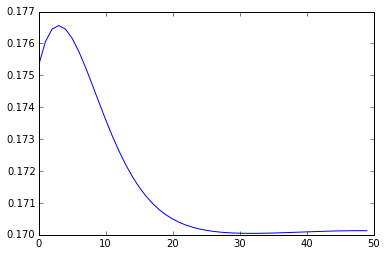

In [62]:
plt.plot(MSE)

In [63]:
data.head()

,x,y,z
0,0.636972,0.242414,0.8
1,0.184778,0.338392,0.2
2,0.175936,0.368622,0.2
3,0.185856,0.544912,0.2
4,0.420365,0.800485,0.8


In [64]:
t = data.copy()

In [65]:
def convert_to_pixel(oldValue):
    oldRange = 1 
    newRange = 255 
    newValue = (((oldValue - 0) * newRange) / oldRange) + 0 #oldMin = newMin = 0
    return math.ceil(newValue)

In [66]:
new_z = t['z'].apply(convert_to_pixel)

In [67]:
t.z = new_z 
t.head()

,x,y,z
0,0.636972,0.242414,204
1,0.184778,0.338392,51
2,0.175936,0.368622,51
3,0.185856,0.544912,51
4,0.420365,0.800485,204


In [69]:
#t = pd.read_csv('donneespb4.txt', sep=' ', header=None)
#t = str_to_float(t)
img = t.values
img

array([[  3.18486003e+02,   1.21206840e+02,   8.00000000e-01],
       [  9.23891998e+01,   1.69196158e+02,   2.00000000e-01],
       [  8.79680666e+01,   1.84310915e+02,   2.00000000e-01],
       ..., 
       [  3.82737700e+02,   3.43214800e+02,   8.00000000e-01],
       [  9.83713296e+01,   1.37674367e+02,   2.00000000e-01],
       [  1.01250648e+02,   3.54561713e+02,   2.00000000e-01]])

In [70]:
imag = Image.fromarray(img)

In [71]:
imag.show()

In [45]:
arr = np.random.randint(0,256, 100*100) 
arr.resize((100,100))
im = Image.fromarray(arr)

In [40]:
im.show()

In [46]:
arr

array([[ 98, 161,  82, ..., 130, 154,  82],
       [143, 146, 181, ..., 223, 127, 135],
       [186, 223, 126, ..., 188, 136, 247],
       ..., 
       [252, 208, 108, ..., 203,  98,  67],
       [253, 120,  46, ..., 246,  77, 197],
       [213, 255, 127, ...,   7, 155, 158]])

In [41]:
img

array([[  6.69566421e-01,   9.09897929e-01,   1.00000000e+00],
       [  2.23555512e-01,   5.17142036e-01,   2.04000000e+02],
       [  5.34524921e-01,   7.57896526e-01,   1.56000000e+02],
       ..., 
       [  9.73577695e-02,   9.99881774e-01,   8.60000000e+01],
       [  2.07353641e-01,   1.92002171e-01,   9.00000000e+00],
       [  9.54042146e-01,   4.46168101e-03,   1.50000000e+01]])